# Dependencies

In [1]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from IPython.display import display

import time
import sys
import gc
import pickle

# Load Data

In [2]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')
test  = pd.read_csv('./input/test.csv').set_index('ID')

# Data Preprocessing
## Outliers

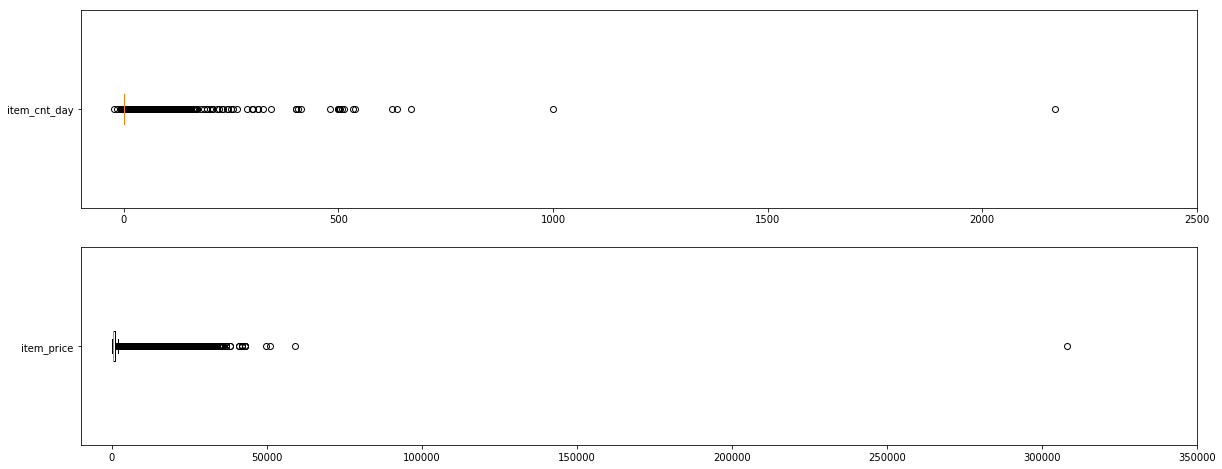

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

ax = axes[0]
ax.set_xlim(-100, 2500)
ax.boxplot([train.item_cnt_day], labels=['item_cnt_day'], vert=False)

ax = axes[1]
ax.set_xlim(-10000, 350000)
ax.boxplot([train.item_price], labels=['item_price'], vert=False)

fig.show()

In [4]:
# remove outliers
display(pd.concat((train[train.item_cnt_day>800], train[train.item_price>100000])))
train = train[train.item_cnt_day<800]
train = train[train.item_price<100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0
1163158,13.12.2013,11,12,6066,307980.000000,1.0


## Fix Data

In [5]:
# fix price less than 0
negtive = train[train.item_price<0]
display(negtive)
sames = train[(train.shop_id==32) & (train.item_id==2973) & (train.date_block_num==4) & (train.item_price>0)]
display(sames)
train.loc[train.item_price<0, 'item_price'] = sames.item_price.mean()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


In [6]:
# Якутск Орджоникидзе, 56
display(shops[(shops.shop_id==0) | (shops.shop_id==57)])
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
display(shops[(shops.shop_id==1) | (shops.shop_id==58)])
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
display(shops[(shops.shop_id==10) | (shops.shop_id==11)])
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57


,shop_name,shop_id
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58


,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


## Shops/Cats/Items preprocessing
- Each shop_name starts with the city name.
- Each category contains type and subtype in its name.

In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
display(shops.head(10))
shops = shops[['shop_id','city_code']]
display(shops.head(10))

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,4
9,Выездная Торговля,9,Выездная,5


,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


In [8]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
display(cats.head(10))
cats = cats[['item_category_id','type_code', 'subtype_code']]
display(cats.head(10))

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13
5,Аксессуары - PSVita,5,"[Аксессуары , PSVita]",Аксессуары,1,PSVita,14
6,Аксессуары - XBOX 360,6,"[Аксессуары , XBOX 360]",Аксессуары,1,XBOX 360,16
7,Аксессуары - XBOX ONE,7,"[Аксессуары , XBOX ONE]",Аксессуары,1,XBOX ONE,17
8,Билеты (Цифра),8,[Билеты (Цифра)],Билеты (Цифра),2,Билеты (Цифра),26
9,Доставка товара,9,[Доставка товара],Доставка товара,3,Доставка товара,33


,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
5,5,1,14
6,6,1,16
7,7,1,17
8,8,2,26
9,9,3,33


In [9]:
display(items.head(10))
items.drop(['item_name'], axis=1, inplace=True)
display(items.head(10))

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
5,5,40
6,6,40
7,7,40
8,8,40
9,9,40


## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [10]:
test_shop_ids = set(test.shop_id)
test_item_ids = set(test.item_id)
train_item_ids = set(train.item_id)
print('Test Set:\n  Shops:', len(list(test_shop_ids)), '\n  Items:', len(list(test_item_ids)), '\n  Total:', len(test))
print('Train Set:\n  Items:', len(list(train_item_ids)))
print('New Items:', len(list(test_item_ids - test_item_ids.intersection(train_item_ids))))

Test Set:
  Shops: 42 
  Items: 5100 
  Total: 214200
Train Set:
  Items: 21806
New Items: 363


In [11]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(len(set(train.date_block_num))):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
display(matrix.head(10))

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32
114603,0,2,33
114604,0,2,34
114902,0,2,35
118327,0,2,40
117720,0,2,41


In [12]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
display(matrix.head(10))

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
5,0,2,33,1.0
6,0,2,34,0.0
7,0,2,35,0.0
8,0,2,40,0.0
9,0,2,41,0.0


In [13]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
display(matrix.tail(10))

,date_block_num,shop_id,item_id,item_cnt_month
11127994,34,45,3280,0.0
11127995,34,45,4393,0.0
11127996,34,45,4352,0.0
11127997,34,45,18049,0.0
11127998,34,45,18027,0.0
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


# Add Features
## Shops/Items/Cats features

In [14]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
display(matrix.head(10))

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4
5,0,2,33,1.0,0,37,11,1
6,0,2,34,0.0,0,40,11,4
7,0,2,35,0.0,0,40,11,4
8,0,2,40,0.0,0,57,13,8
9,0,2,41,0.0,0,57,13,8


## Traget lags

In [15]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    prev = 0
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [16]:
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'item_cnt_month')
display(matrix.tail(10))

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6
11127994,34,45,3280,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0
11127995,34,45,4393,0.0,20,22,5,14,0.0,0.0,0.0,0.0,NaN,0.0
11127996,34,45,4352,0.0,20,22,5,14,0.0,0.0,0.0,0.0,0.0,0.0
11127997,34,45,18049,0.0,20,70,14,57,0.0,0.0,0.0,1.0,1.0,1.0
11127998,34,45,18027,0.0,20,70,14,57,0.0,0.0,0.0,0.0,0.0,NaN
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.0
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,NaN
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0
11128003,34,45,969,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0


## Mean encoded features

In [17]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105,0.31665
5000008,13,29,21784,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665
5000009,13,29,21787,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665
5000010,13,29,21790,0.0,13,61,14,20,0.0,NaN,NaN,NaN,NaN,NaN,0.311279,NaN,NaN,NaN,NaN,NaN


In [18]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.065247,0.086975,0.044434,0.065247,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105,0.31665,NaN,NaN,0.044434,0.065247,0.022217,0.266602
5000008,13,29,21784,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.043488,0.044434,0.043488,0.044434,0.088867
5000009,13,29,21787,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.217407,0.391357,0.155518,0.152222,0.088867,0.111084
5000010,13,29,21790,0.0,13,61,14,20,0.0,NaN,NaN,NaN,NaN,NaN,0.311279,NaN,NaN,NaN,NaN,NaN,0.021744,NaN,NaN,NaN,NaN,NaN


In [19]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.065247,0.086975,0.044434,0.065247,NaN,NaN,0.251953,0.335205,0.266357,0.243286,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105,0.31665,NaN,NaN,0.044434,0.065247,0.022217,0.266602,NaN,NaN,0.266357,0.243286,0.286621,0.239502
5000008,13,29,21784,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.043488,0.044434,0.043488,0.044434,0.088867,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502
5000009,13,29,21787,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.217407,0.391357,0.155518,0.152222,0.088867,0.111084,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502
5000010,13,29,21790,0.0,13,61,14,20,0.0,NaN,NaN,NaN,NaN,NaN,0.311279,NaN,NaN,NaN,NaN,NaN,0.021744,NaN,NaN,NaN,NaN,NaN,0.251953,NaN,NaN,NaN,NaN,NaN


In [20]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,NaN,NaN,NaN,NaN,0.159790,0.123169,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.065247,0.086975,0.044434,0.065247,NaN,NaN,0.251953,0.335205,0.266357,0.243286,NaN,NaN,0.159790,0.123169,0.101257,0.080688,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105,0.31665,NaN,NaN,0.044434,0.065247,0.022217,0.266602,NaN,NaN,0.266357,0.243286,0.286621,0.239502,NaN,NaN,1.117188,1.301758,1.333008,1.302734
5000008,13,29,21784,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.043488,0.044434,0.043488,0.044434,0.088867,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.092834,0.115967,0.097900,0.093994,0.082031,0.099609
5000009,13,29,21787,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.217407,0.391357,0.155518,0.152222,0.088867,0.111084,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.092834,0.115967,0.097900,0.093994,0.082031,0.099609
5000010,13,29,21790,0.0,13,61,14,20,0.0,NaN,NaN,NaN,NaN,NaN,0.311279,NaN,NaN,NaN,NaN,NaN,0.021744,NaN,NaN,NaN,NaN,NaN,0.251953,NaN,NaN,NaN,NaN,NaN,0.159790,NaN,NaN,NaN,NaN,NaN


In [21]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,NaN,NaN,NaN,NaN,0.159790,0.123169,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.065247,0.086975,0.044434,0.065247,NaN,NaN,0.251953,0.335205,0.266357,0.243286,NaN,NaN,0.159790,0.123169,0.101257,0.080688,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105,0.31665,NaN,NaN,0.044434,0.065247,0.022217,0.266602,NaN,NaN,0.266357,0.243286,0.286621,0.239502,NaN,NaN,1.117188,1.301758,1.333008,1.302734,NaN,NaN,0.981934,1.080078,1.225586,0.976074
5000008,13,29,21784,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.043488,0.044434,0.043488,0.044434,0.088867,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.092834,0.115967,0.097900,0.093994,0.082031,0.099609,0.000000,0.000000,0.000000,0.000000,0.004166,0.000000
5000009,13,29,21787,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.217407,0.391357,0.155518,0.152222,0.088867,0.111084,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.092834,0.115967,0.097900,0.093994,0.082031,0.099609,0.000000,0.000000,0.000000,0.000000,0.004166,0.000000
5000010,13,29,21790,0.0,13,61,14,20,0.0,NaN,NaN,NaN,NaN,NaN,0.311279,NaN,NaN,NaN,NaN,NaN,0.021744,NaN,NaN,NaN,NaN,NaN,0.251953,NaN,NaN,NaN,NaN,NaN,0.159790,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [22]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,NaN,NaN,NaN,NaN,0.159790,0.123169,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.183350,0.274414,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.065247,0.086975,0.044434,0.065247,NaN,NaN,0.251953,0.335205,0.266357,0.243286,NaN,NaN,0.159790,0.123169,0.101257,0.080688,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.183350,0.274414,0.136108,0.130981,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105,0.31665,NaN,NaN,0.044434,0.065247,0.022217,0.266602,NaN,NaN,0.266357,0.243286,0.286621,0.239502,NaN,NaN,1.117188,1.301758,1.333008,1.302734,NaN,NaN,0.981934,1.080078,1.225586,0.976074,NaN,NaN,0.763672,0.708496,0.875000,0.694336
5000008,13,29,21784,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.043488,0.044434,0.043488,0.044434,0.088867,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.092834,0.115967,0.097900,0.093994,0.082031,0.099609,0.000000,0.000000,0.000000,0.000000,0.004166,0.000000,0.017136,0.010307,0.027542,0.033691,0.037140,0.012886
5000009,13,29,21787,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.217407,0.391357,0.155518,0.152222,0.088867,0.111084,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.092834,0.115967,0.097900,0.09

In [23]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,NaN,NaN,NaN,NaN,0.159790,0.123169,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.183350,0.274414,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.065247,0.086975,0.044434,0.065247,NaN,NaN,0.251953,0.335205,0.266357,0.243286,NaN,NaN,0.159790,0.123169,0.101257,0.080688,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.183350,0.274414,0.136108,0.130981,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105,0.31665,NaN,NaN,0.044434,0.065247,0.022217,0.266602,NaN,NaN,0.266357,0.243286,0.286621,0.239502,NaN,NaN,1.117188,1.301758,1.333008,1.302734,NaN,NaN,0.981934,1.080078,1.225586,0.976074,NaN,NaN,0.763672,0.708496,0.875000,0.694336,NaN,NaN,0.981934,1.080078,1.225586,0.976074
5000008,13,29,21784,0.0,13,43,12,21,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.043488,0.04

In [24]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,NaN,NaN,NaN,NaN,0.159790,0.123169,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.183350,0.274414,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.494629,0.645996,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.065247,0.086975,0.044434,0.065247,NaN,NaN,0.251953,0.335205,0.266357,0.243286,NaN,NaN,0.159790,0.123169,0.101257,0.080688,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.183350,0.274414,0.136108,0.130981,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.494629,0.645996,0.467529,0.443848,NaN,NaN
5000007,13,29,21782,0.0,13,30,8,55,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.303223,0.290039,0.308105

In [25]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,NaN,NaN,NaN,NaN,0.159790,0.123169,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.183350,0.274414,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.494629,0.645996,NaN,NaN,NaN,NaN,0.899902,0.799805,NaN,NaN,NaN,NaN
5000006,13,29,21775,0.0,13,61,14,20,0.0,0.0,0.0,0.0,NaN,NaN,0.311279,0.411377,0.303223,0.290039,NaN,NaN,0.06524

In [26]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.788574,0.915039,0.882812
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000005,13,29,21772,0.0,13,61,14,20,0.0,0.0,NaN,NaN,NaN,NaN,0.311279,0.411377,NaN,NaN,NaN,NaN,0.326172,0.260986,NaN,NaN,NaN,NaN,0.251953,0.335205,N

In [27]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.788574,0.915039,0.882812,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734
5000003,13,29,21769,0.0,13,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000004,13,29,21770,0.0,13,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Trend features
Price trend for the last six months.

In [28]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']
    matrix['delta_price_lag_'+str(i)].fillna(0, inplace=True)
    
for i in lags[:-1]:
    matrix['delta_delta_price_lag_'+str(i)] =  matrix['delta_price_lag_'+str(i)] - matrix['delta_price_lag_'+str(i+1)]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    #fetures_to_drop += ['delta_price_lag_'+str(i)]    

matrix.drop(fetures_to_drop, axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.788574,0.915039,0.882812,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,-0.211182,-0.211182,-0.011955,-0.011955,-0.011955,-0.011955,0.000000,-0.199219,0.000000,0.000000,0.000000
5000003,

In [29]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 6], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_4,delta_revenue_lag_5,delta_revenue_lag_6
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165,-0.026428,0.947754,0.414551,0.019913,0.446289,-0.319092
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.788574,0.915039,0

## Special features

In [30]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_4,delta_revenue_lag_5,delta_revenue_lag_6,month,days
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165,-0.026428,0.947754,0.414551,0.019913,0.446289,-0.319092,1,28
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.7

In [31]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num 
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_4,delta_revenue_lag_5,delta_revenue_lag_6,month,days,item_shop_last_sale
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165,-0.026428,0.947754,0.414551,0.019913,0.446289,-0.319092,1,28,2
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527

In [32]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,...,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_4,delta_revenue_lag_5,delta_revenue_lag_6,month,days,item_shop_last_sale,item_last_sale
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,...,0.260986,0.255127,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165,-0.026428,0.947754,0.414551,0.019913,0.446289,-0.319092,1,28,2,0
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,...,1.168945,0.981934,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.78857

In [33]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,...,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_4,delta_revenue_lag_5,delta_revenue_lag_6,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,...,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165,-0.026428,0.947754,0.414551,0.019913,0.446289,-0.319092,1,28,2,0,13,13
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,...,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.788574,0.915039,0.882812,1.226562,1.430664,1.117188,1.301758,1.333008,1.

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [34]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

In [35]:
matrix = matrix[matrix.date_block_num > 5]
matrix = fill_na(matrix)
matrix.columns
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,...,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_4,delta_revenue_lag_5,delta_revenue_lag_6,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,...,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165,-0.026428,0.947754,0.414551,0.019913,0.446289,-0.319092,1,28,2,0,13,13
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,...,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.788574,0.915039,0.882812,1.226562,1.430664,1.117188,1.301758,1.333008,1.

In [36]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8865296 entries, 2262708 to 11128003
Columns: 103 entries, date_block_num to item_first_sale
dtypes: float16(90), int16(1), int8(12)
memory usage: 1.7 GB


In [37]:
display(matrix.loc[5000001:5000010])

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_4,date_avg_item_cnt_lag_5,date_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_4,date_cat_avg_item_cnt_lag_5,date_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_4,date_shop_cat_avg_item_cnt_lag_5,date_shop_cat_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_4,date_shop_type_avg_item_cnt_lag_5,date_shop_type_avg_item_cnt_lag_6,...,date_shop_subtype_avg_item_cnt_lag_4,date_shop_subtype_avg_item_cnt_lag_5,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_5,date_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_4,date_item_city_avg_item_cnt_lag_5,date_item_city_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_4,date_type_avg_item_cnt_lag_5,date_type_avg_item_cnt_lag_6,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_4,date_subtype_avg_item_cnt_lag_5,date_subtype_avg_item_cnt_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_delta_price_lag_1,delta_delta_price_lag_2,delta_delta_price_lag_3,delta_delta_price_lag_4,delta_delta_price_lag_5,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_4,delta_revenue_lag_5,delta_revenue_lag_6,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
5000001,13,29,21767,0.0,13,40,11,4,0.0,1.0,0.0,0.0,1.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.369629,0.239136,0.266602,0.304443,0.199951,0.222168,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.215454,0.260986,0.255127,0.197876,0.232544,0.204956,0.197388,0.236328,0.230835,0.171875,0.226562,0.196533,...,0.197876,0.232544,0.204956,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.300049,0.500000,0.199951,0.600098,0.199951,0.199951,0.230591,0.270020,0.221436,0.209961,0.213501,0.229004,0.257568,0.291504,0.244873,0.236206,0.227539,0.238403,0.008781,0.046539,-0.061462,0.046539,0.040375,0.046539,-0.037750,0.108032,-0.108032,0.006165,-0.006165,-0.026428,0.947754,0.414551,0.019913,0.446289,-0.319092,1,28,2,0,13,13
5000002,13,29,21768,0.0,13,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.311279,0.411377,0.303223,0.290039,0.308105,0.31665,0.021744,0.021744,0.044434,0.043488,0.111084,0.066650,0.251953,0.335205,0.266357,0.243286,0.286621,0.239502,1.226562,1.430664,1.117188,1.301758,1.333008,1.302734,0.916504,1.168945,0.981934,1.080078,1.225586,0.976074,0.509277,0.732910,0.763672,0.708496,0.875000,0.694336,...,1.080078,1.225586,0.976074,0.494629,0.645996,0.467529,0.443848,0.481689,0.483398,0.000000,0.000000,0.000000,0.000000,0.000000,0.099976,0.665527,0.863281,0.824219,0.788574,0.915039,0.882812,1.226562,1.430664,1.117188,1.301758,1.333008,1.

In [38]:
matrix.to_pickle('data_all_fix_last_sale.pkl')